In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

import re


## Import and download datasets

In [2]:
path_dataset = r'C:\Users\user\GoogleTrends\dataset'

In [3]:
url = 'https://trends.google.com/trends/api/explore/pickers/category?hl=en-US&tz=240'
req = requests.get(url)

regex = r'"name":"(\w+).*?"id":(\d+)'
matches = re.findall(regex, req.text)

dict_category = pd.DataFrame(matches, columns=['cat_name','cat_number'])
dict_category['cat_number'] = dict_category['cat_number'].astype('int')
dict_category = dict_category.set_index('cat_number')

In [4]:
google_trends = pd.read_csv(os.path.join(path_dataset, 'DE.csv'))
google_trends['date'] = pd.to_datetime(google_trends['date'])
google_trends = google_trends.pivot_table(index='date', values='value', columns='cat')
google_trends.index = pd.to_datetime(google_trends.index)

google_trends.columns = list(dict_category.loc[google_trends.columns]['cat_name'].drop_duplicates())
google_trends

,Arts,Computers,Finance,Games,Home,Business,Internet,People,News,Shopping,...,Health,Autos,Hobbies,Pets,Travel,Food,Science,Online,Reference,Jobs
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,12.0,11.0,8.0,9.0,13.0,6.0,11.0,4.0,7.0,5.0,...,12.0,10.0,2.0,5.0,16.0,6.0,3.0,5.0,5.0,1.0
2004-01-02,78.0,78.0,77.0,76.0,82.0,65.0,81.0,76.0,54.0,73.0,...,75.0,65.0,78.0,63.0,68.0,79.0,51.0,76.0,75.0,59.0
2004-01-03,80.0,81.0,56.0,90.0,78.0,60.0,79.0,76.0,49.0,85.0,...,66.0,62.0,72.0,69.0,67.0,87.0,55.0,81.0,67.0,53.0
2004-01-04,86.0,85.0,62.0,93.0,81.0,70.0,85.0,86.0,57.0,75.0,...,83.0,71.0,78.0,78.0,81.0,79.0,61.0,81.0,78.0,67.0
2004-01-05,22.0,23.0,27.0,23.0,21.0,20.0,26.0,25.0,19.0,20.0,...,26.0,20.0,19.0,21.0,22.0,15.0,19.0,21.0,24.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,73.0,95.0,87.0,75.0,83.0,85.0,92.0,87.0,51.0,79.0,...,89.0,84.0,73.0,76.0,57.0,72.0,90.0,88.0,97.0,86.0
2022-11-03,76.0,92.0,83.0,76.0,83.0,89.0,91.0,86.0,51.0,80.0,...,91.0,82.0,72.0,79.0,54.0,74.0,90.0,90.0,96.0,91.0
2022-11-04,83.0,93.0,82.0,83.0,87.0,87.0,91.0,89.0,53.0,82.0,...,84.0,84.0,73.0,77.0,58.0,85.0,85.0,92.0,89.0,77.0


In [5]:
google_trends.loc['2018':'2019'].iplot()

In [6]:
google_trends.loc['2018':'2019', ['Business','Jobs']].iplot()

<AxesSubplot: xlabel='date'>

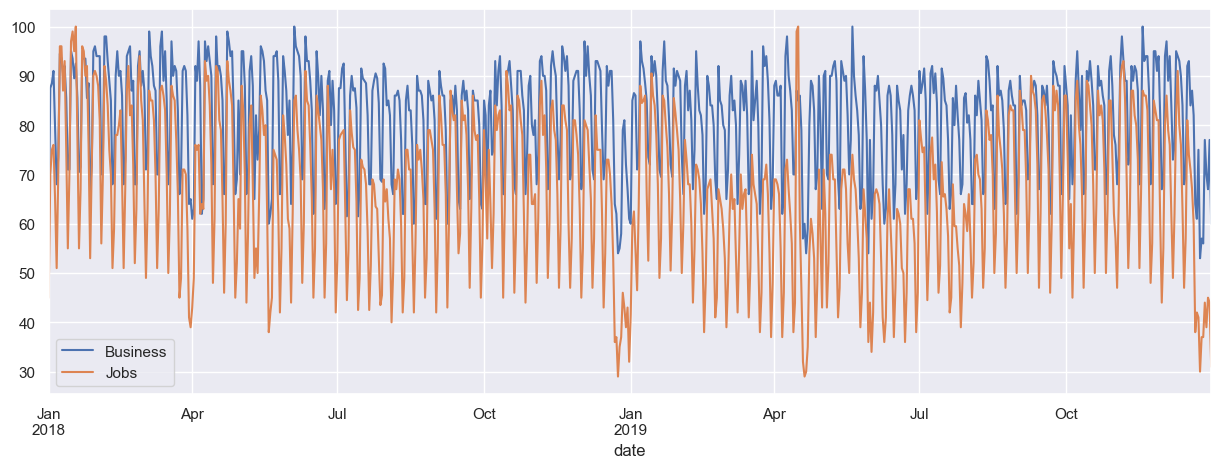

In [7]:
google_trends.loc['2018':'2019', ['Business','Jobs']].plot(figsize=(15,5))

In [8]:
df_holiday = []

for year in np.arange(2004, 2022+1):
    holiday_temp = pd.read_html('https://www.timeanddate.com/holidays/germany/'+str(year)+'?hol=9')[0]
    holiday_temp.columns = holiday_temp.columns.get_level_values(0)
    holiday_temp = holiday_temp[~holiday_temp['Date'].str.contains('Observed').fillna(False)]
    holiday_temp = holiday_temp[holiday_temp['Type'].str.contains('National').fillna(False)]
    holiday_temp = holiday_temp.dropna(how='all')
    holiday_temp = holiday_temp[['Date', 'Name', 'Type']]
    holiday_temp['Date'] = str(year) + ' ' + holiday_temp['Date']
    holiday_temp['Date'] = pd.to_datetime(holiday_temp['Date'])
    
    df_holiday.append(holiday_temp)
    
df_holiday = pd.concat(df_holiday, axis=0, ignore_index=True)

df_holiday = df_holiday.drop_duplicates(subset=['Date'])
df_holiday = df_holiday.set_index('Date').asfreq('D')
df_holiday.loc[df_holiday.index.weekday>=5, 'Name'] = 'weekend'
df_holiday.loc[df_holiday.index.weekday>=5, 'Type'] = 'weekend'
df_holiday['Name'] = df_holiday['Name'].fillna('weekday')
df_holiday['Type'] = df_holiday['Type'].fillna('weekday')
df_holiday.columns = 'holiday_' + df_holiday.columns

df_holiday = df_holiday.reset_index()
df_holiday = df_holiday.rename(columns={'Date':'date'}) 

In [9]:
df_holiday_encode = df_holiday.copy()
df_holiday_encode[['holiday_Name', 'holiday_Type']] = df_holiday_encode[['holiday_Name', 'holiday_Type']].astype('str').apply(preprocessing.LabelEncoder().fit_transform)
df_holiday_encode.columns = df_holiday_encode.columns+'_encode'
df_holiday_encode = df_holiday_encode.rename(columns={'date_encode':'date'})
df_holiday_encode

,date,holiday_Name_encode,holiday_Type_encode
0,2004-01-01,7,0
1,2004-01-02,10,2
2,2004-01-03,11,3
3,2004-01-04,11,3
4,2004-01-05,10,2
...,...,...,...
6930,2022-12-22,10,2
6931,2022-12-23,10,2
6932,2022-12-24,11,3
6933,2022-12-25,11,3


## Prediction model: Business trends

In [10]:
df_dataset = google_trends['Business'].rename('trends').to_frame().copy()


index_temp = df_dataset.index.copy()

#df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['month'] = df_dataset.index.month.astype('int')
df_dataset['day'] = df_dataset.index.day.astype('int')
#df_dataset['dayofyear'] = df_dataset.index.dayofyear.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
#df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
#df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24


df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.merge(df_holiday_encode, on='date')

shift_number = 1
for shift in np.arange(-shift_number,shift_number+1):
    df_dataset['holiday_Name_encode_shift'+str(shift)] = df_dataset['holiday_Name_encode'].shift(shift)
    df_dataset['holiday_Type_encode_shift'+str(shift)] = df_dataset['holiday_Type_encode'].shift(shift)
    
#df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp

df_dataset['trends'] = (df_dataset['trends']-df_dataset.groupby('year')['trends'].transform('mean'))/df_dataset.groupby('year')['trends'].transform('std')

df_dataset

,date,trends,year,month,day,weekday,holiday_Name,holiday_Type,holiday_Name_encode,holiday_Type_encode,holiday_Name_encode_shift-1,holiday_Type_encode_shift-1,holiday_Name_encode_shift0,holiday_Type_encode_shift0,holiday_Name_encode_shift1,holiday_Type_encode_shift1
date,,,,,,,,,,,,,,,,
2004-01-01,2004-01-01,-3.243739,2004,1,1,3,New Year's Day,National holiday,7,0,10.0,2.0,7,0,NaN,NaN
2004-01-02,2004-01-02,-0.101426,2004,1,2,4,weekday,weekday,10,2,11.0,3.0,10,2,7.0,0.0
2004-01-03,2004-01-03,-0.367724,2004,1,3,5,weekend,weekend,11,3,11.0,3.0,11,3,10.0,2.0
2004-01-04,2004-01-04,0.164872,2004,1,4,6,weekend,weekend,11,3,10.0,2.0,11,3,11.0,3.0
2004-01-05,2004-01-05,-2.498105,2004,1,5,0,weekday,weekday,10,2,10.0,2.0,10,2,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,2022-11-02,1.217494,2022,11,2,2,weekday,weekday,10,2,10.0,2.0,10,2,10.0,2.0
2022-11-03,2022-11-03,1.562134,2022,11,3,3,weekday,weekday,10,2,10.0,2.0,10,2,10.0,2.0
2022-11-04,2022-11-04,1.389814,2022,11,4,4,weekday,weekday,10,2,11.0,3.0,10,2,10.0,2.0


In [11]:
list_feat = df_dataset.select_dtypes(['int','float']).drop(['trends','year'],axis=1).columns
list_feat

Index(['month', 'day', 'weekday', 'holiday_Name_encode', 'holiday_Type_encode',
       'holiday_Name_encode_shift-1', 'holiday_Type_encode_shift-1',
       'holiday_Name_encode_shift0', 'holiday_Type_encode_shift0',
       'holiday_Name_encode_shift1', 'holiday_Type_encode_shift1'],
      dtype='object')

In [12]:
traindata = df_dataset[df_dataset['year']%2==0].copy()
testdata = df_dataset[df_dataset['year']%2==1].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['trends'])
testdata['trends_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['trends_pred'] - testdata['trends'])
RSQUARED = r2_score(testdata['trends'], testdata['trends_pred'])
MAE = mean_absolute_error(testdata['trends'], testdata['trends_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

Model: LGBM
R SQUARED: 0.8563
MAE: 0.2757


In [13]:
testdata[['trends','trends_pred','holiday_Type_encode']].iplot()

<AxesSubplot: title={'center': 'Trends of Business'}, xlabel='date'>

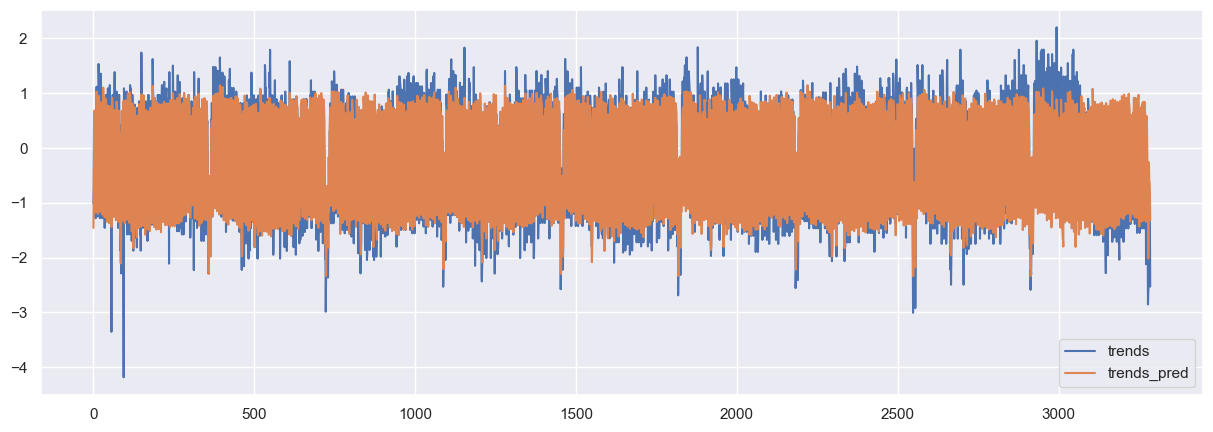

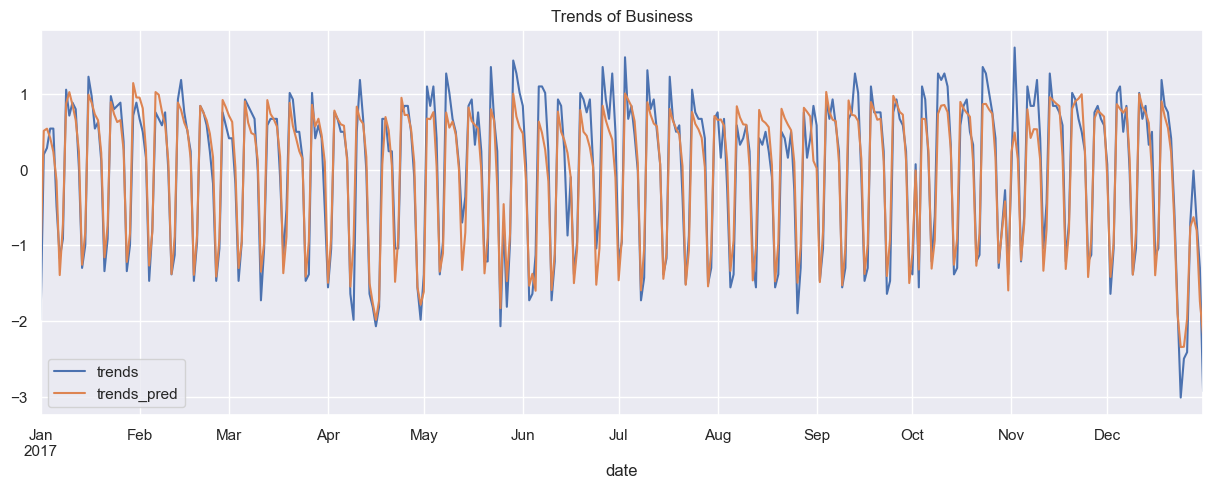

In [14]:
testdata[['trends','trends_pred']].reset_index(drop=True).plot(figsize=(15,5))
testdata[['trends','trends_pred']].loc['2017'].plot(figsize=(15,5), title='Trends of Business')

In [15]:
for year in testdata['year'].unique():
    print(year)
    RSQUARED = r2_score(testdata.loc[testdata['year']==year,'trends'], testdata.loc[testdata['year']==year,'trends_pred'])
    print("R SQUARED: "+str(round(RSQUARED,4)))

2005
R SQUARED: 0.7739
2007
R SQUARED: 0.8885
2009
R SQUARED: 0.924
2011
R SQUARED: 0.9128
2013
R SQUARED: 0.9258
2015
R SQUARED: 0.9075
2017
R SQUARED: 0.9122
2019
R SQUARED: 0.8844
2021
R SQUARED: 0.5776


## Prediction model: Jobs trends

In [16]:
df_dataset = google_trends['Jobs'].rename('trends').to_frame().copy()


index_temp = df_dataset.index.copy()

#df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['month'] = df_dataset.index.month.astype('int')
df_dataset['day'] = df_dataset.index.day.astype('int')
#df_dataset['dayofyear'] = df_dataset.index.dayofyear.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
#df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
#df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24


df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.merge(df_holiday_encode, on='date')

shift_number = 1
for shift in np.arange(-shift_number,shift_number+1):
    df_dataset['holiday_Name_encode_shift'+str(shift)] = df_dataset['holiday_Name_encode'].shift(shift)
    df_dataset['holiday_Type_encode_shift'+str(shift)] = df_dataset['holiday_Type_encode'].shift(shift)
    
#df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp

df_dataset['trends'] = (df_dataset['trends']-df_dataset.groupby('year')['trends'].transform('mean'))/df_dataset.groupby('year')['trends'].transform('std')

df_dataset

,date,trends,year,month,day,weekday,holiday_Name,holiday_Type,holiday_Name_encode,holiday_Type_encode,holiday_Name_encode_shift-1,holiday_Type_encode_shift-1,holiday_Name_encode_shift0,holiday_Type_encode_shift0,holiday_Name_encode_shift1,holiday_Type_encode_shift1
date,,,,,,,,,,,,,,,,
2004-01-01,2004-01-01,-3.361294,2004,1,1,3,New Year's Day,National holiday,7,0,10.0,2.0,7,0,NaN,NaN
2004-01-02,2004-01-02,-0.200001,2004,1,2,4,weekday,weekday,10,2,11.0,3.0,10,2,7.0,0.0
2004-01-03,2004-01-03,-0.527031,2004,1,3,5,weekend,weekend,11,3,11.0,3.0,11,3,10.0,2.0
2004-01-04,2004-01-04,0.236040,2004,1,4,6,weekend,weekend,11,3,10.0,2.0,11,3,11.0,3.0
2004-01-05,2004-01-05,-2.325698,2004,1,5,0,weekday,weekday,10,2,10.0,2.0,10,2,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,2022-11-02,1.289710,2022,11,2,2,weekday,weekday,10,2,10.0,2.0,10,2,10.0,2.0
2022-11-03,2022-11-03,1.650614,2022,11,3,3,weekday,weekday,10,2,10.0,2.0,10,2,10.0,2.0
2022-11-04,2022-11-04,0.640082,2022,11,4,4,weekday,weekday,10,2,11.0,3.0,10,2,10.0,2.0


In [17]:
list_feat = df_dataset.select_dtypes(['int','float']).drop(['trends','year'],axis=1).columns
list_feat

Index(['month', 'day', 'weekday', 'holiday_Name_encode', 'holiday_Type_encode',
       'holiday_Name_encode_shift-1', 'holiday_Type_encode_shift-1',
       'holiday_Name_encode_shift0', 'holiday_Type_encode_shift0',
       'holiday_Name_encode_shift1', 'holiday_Type_encode_shift1'],
      dtype='object')

In [18]:
traindata = df_dataset[df_dataset['year']%2==0].copy()
testdata = df_dataset[df_dataset['year']%2==1].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['trends'])
testdata['trends_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['trends_pred'] - testdata['trends'])
RSQUARED = r2_score(testdata['trends'], testdata['trends_pred'])
MAE = mean_absolute_error(testdata['trends'], testdata['trends_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

Model: LGBM
R SQUARED: 0.8223
MAE: 0.3193


In [19]:
testdata[['trends','trends_pred','holiday_Type_encode']].iplot()

<AxesSubplot: title={'center': 'Trends of Jobs'}, xlabel='date'>

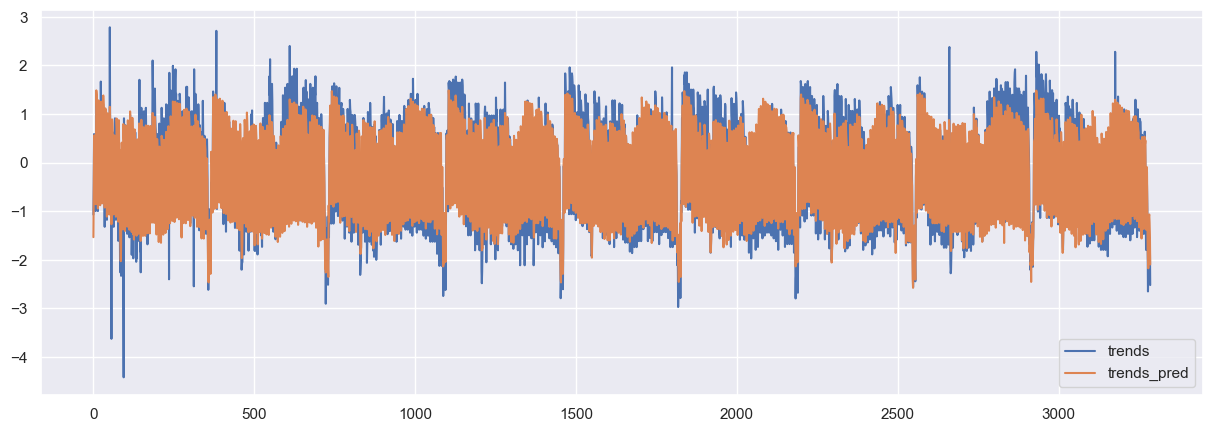

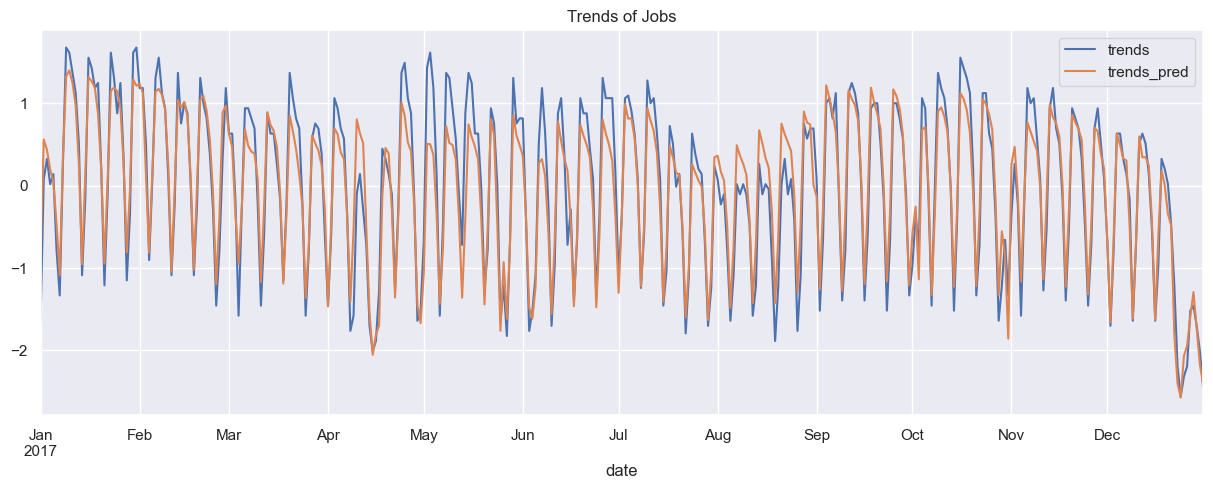

In [20]:
testdata[['trends','trends_pred']].reset_index(drop=True).plot(figsize=(15,5))
testdata[['trends','trends_pred']].loc['2017'].plot(figsize=(15,5), title='Trends of Jobs')

In [21]:
for year in testdata['year'].unique():
    print(year)
    RSQUARED = r2_score(testdata.loc[testdata['year']==year,'trends'], testdata.loc[testdata['year']==year,'trends_pred'])
    print("R SQUARED: "+str(round(RSQUARED,4)))

2005
R SQUARED: 0.6381
2007
R SQUARED: 0.7321
2009
R SQUARED: 0.9017
2011
R SQUARED: 0.8892
2013
R SQUARED: 0.9059
2015
R SQUARED: 0.8508
2017
R SQUARED: 0.8918
2019
R SQUARED: 0.7996
2021
R SQUARED: 0.7917
